### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [124]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500
config.num_classes = 10

### Создаем dataloader

In [125]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [126]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

### Создаем модель GAN

In [127]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(config.noise_size, 200),
#             nn.ReLU(inplace=True),
#             nn.Linear(200, 28*28),
#             nn.Sigmoid())

#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(28*28, 200),
#             nn.ReLU(inplace=True),
#             nn.Linear(200, 50),
#             nn.ReLU(inplace=True),
#             nn.Linear(50, 1),
#             nn.Sigmoid())
#     def forward(self, x):
#         return self.model(x)


class ConditionalGenerator(nn.Module):
    def __init__(self, noise_size, num_classes, hidden_size=200):
        super(ConditionalGenerator, self).__init__()
        self.embedding = nn.Embedding(num_classes, noise_size)
        self.model = nn.Sequential(
            # nn.Linear(noise_size + num_classes, hidden_size),
            nn.Linear(noise_size + noise_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        embedded_labels = self.embedding(labels)
        x = torch.cat([noise, embedded_labels], dim=1)
        return self.model(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, hidden_size=200):
        super(ConditionalDiscriminator, self).__init__()
        self.embedding = nn.Embedding(num_classes, 28*28)
        self.model = nn.Sequential(
            # nn.Linear(28*28 + num_classes, hidden_size),
            nn.Linear(28*28 + 28*28, hidden_size), #28*28 - сама картинка + 28*28 - размер embedding
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, image, labels):
        embedded_labels = self.embedding(labels)
        x = torch.cat([image, embedded_labels], dim=1)
        return self.model(x)



In [128]:
# generator = Generator()
# discriminator = Discriminator()
conditional_generator = ConditionalGenerator(config.noise_size, config.num_classes)
conditional_discriminator = ConditionalDiscriminator(config.num_classes)

### Оптимизатор и функция потерь

In [129]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# generator = generator.to(device)
# discriminator = discriminator.to(device)
conditional_generator = conditional_generator.to(device)
conditional_discriminator = conditional_discriminator.to(device)
# optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
# optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
optim_G = optim.Adam(params=conditional_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=conditional_discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [130]:
#noise = Variable(torch.cuda.FloatTensor(config.batch_size, config.noise_size, device=device))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
# fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))
# label = Variable(torch.cuda.FloatTensor(config.batch_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1.
fake_label = 0.

### GAN обучение

In [131]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

# Клипинг весов после каждого обновления параметров
clip_value = 0.01

# Штраф градиентов
lambda_gp = 10  # Коэффициент штрафа градиентов

for epoch in range(config.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        conditional_discriminator.zero_grad()

        # real
        label_real = torch.full((images.size(0),), real_label, device=device)
        input_data = images.view(images.shape[0], -1)
        output_real = conditional_discriminator(input_data, labels).view(-1)
        errD_x = criterion(output_real, label_real)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake = conditional_generator(noise, labels)
        label_fake = torch.full((images.size(0),), fake_label, device=device)
        output_fake = conditional_discriminator(fake.detach(), labels).view(-1)
        errD_z = criterion(output_fake, label_fake)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        # Gradient penalty
        gradient_penalty = 0
        for p in conditional_discriminator.parameters():
            gradient_penalty += (p.grad.norm(2) - 1) ** 2
        errD_z += lambda_gp * gradient_penalty

        optim_D.step()

        # Clip discriminator weights (optional)
        for p in conditional_discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Generator stage
        conditional_generator.zero_grad()
        label_real = torch.full((images.size(0),), real_label, device=device)
        output_fake = conditional_discriminator(fake, labels).view(-1)
        errG = criterion(output_fake, label_real)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch + 1,
                                                                                        iteration + 1,
                                                                                        errD_x.item(),
                                                                                        errD_z.item(),
                                                                                        errG.item()))



Epoch:1 Iter: 500 errD_x: 0.66 errD_z: 59.75 errG: 0.69
Epoch:1 Iter: 1000 errD_x: 0.70 errD_z: 64.65 errG: 0.71
Epoch:1 Iter: 1500 errD_x: 0.69 errD_z: 64.72 errG: 0.70
Epoch:1 Iter: 2000 errD_x: 0.69 errD_z: 64.55 errG: 0.70
Epoch:1 Iter: 2500 errD_x: 0.69 errD_z: 68.18 errG: 0.70
Epoch:1 Iter: 3000 errD_x: 0.67 errD_z: 66.11 errG: 0.68
Epoch:1 Iter: 3500 errD_x: 0.68 errD_z: 65.24 errG: 0.69
Epoch:2 Iter: 500 errD_x: 0.68 errD_z: 64.87 errG: 0.70
Epoch:2 Iter: 1000 errD_x: 0.70 errD_z: 66.79 errG: 0.70
Epoch:2 Iter: 1500 errD_x: 0.68 errD_z: 66.62 errG: 0.69
Epoch:2 Iter: 2000 errD_x: 0.69 errD_z: 66.22 errG: 0.70
Epoch:2 Iter: 2500 errD_x: 0.69 errD_z: 66.43 errG: 0.70
Epoch:2 Iter: 3000 errD_x: 0.69 errD_z: 66.68 errG: 0.70
Epoch:2 Iter: 3500 errD_x: 0.69 errD_z: 66.72 errG: 0.70
Epoch:3 Iter: 500 errD_x: 0.68 errD_z: 66.01 errG: 0.69
Epoch:3 Iter: 1000 errD_x: 0.69 errD_z: 67.26 errG: 0.70
Epoch:3 Iter: 1500 errD_x: 0.68 errD_z: 66.38 errG: 0.69
Epoch:3 Iter: 2000 errD_x: 0.69 er

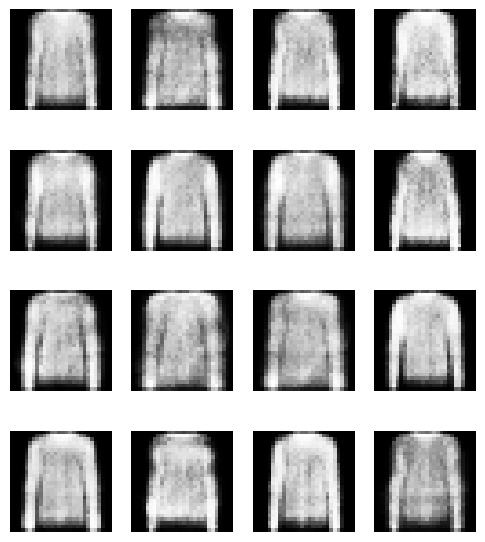

In [133]:
noise.data.normal_(0, 1)
labels = torch.full((16,), 2, device=device)
fake = conditional_generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # tensor_cpu = fake[i].detach().cpu()
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    # plt.imshow(tensor_cpu.numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')